In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score


## The Dataset

In [28]:
from google.colab import drive

In [29]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
data=pd.read_csv('/content/drive/MyDrive/Dataset/Brain Stroke Prediction Dataset.csv')

In [31]:
data

,Gender,Age,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose level,BMI,Smoking Status,Stroke
0,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
1,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
2,Male,36.0,0,0,Yes,Private,Urban,77.26,30.9,never smoked,0
3,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
4,Female,31.0,0,0,Yes,Private,Rural,77.01,31.3,formerly smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
245,Male,62.0,0,0,Yes,Private,Urban,81.64,38.2,never smoked,0
246,Male,5.0,0,0,No,children,Rural,97.64,17.0,Unknown,0
247,Female,43.0,0,0,Yes,Private,Rural,110.32,28.4,never smoked,0
248,Female,39.0,0,0,No,Private,Rural,79.00,30.0,never smoked,0


In [32]:
data.describe()

,Age,Hypertension,Heart Disease,Average Glucose level,BMI,Stroke
count,250.000000,250.000000,250.000000,250.000000,225.000000,250.000000
mean,51.555520,0.180000,0.084000,115.636320,28.978667,0.424000
std,23.672686,0.384958,0.277944,51.863597,7.636630,0.495182
min,0.160000,0.000000,0.000000,56.110000,13.000000,0.000000
25%,35.250000,0.000000,0.000000,77.072500,24.000000,0.000000
50%,57.500000,0.000000,0.000000,97.280000,28.400000,0.000000
75%,72.000000,0.000000,0.000000,136.095000,32.900000,1.000000
max,82.000000,1.000000,1.000000,271.740000,55.000000,1.000000


## Handling Missing Value

In [33]:
# Safely disable new warning with the chained assignment.
pd.options.mode.chained_assignment = None  # default='warn'
# replace missing values in variable 'bmi' with its mean
data['BMI']=data['BMI'].fillna(data['BMI'].mean())
# remove (drop) data associated with missing values in variable 'smoking_status'
clean_data = data[data['Smoking Status'].notnull()]
# validate there's no more missing values
miss_val = clean_data.isnull().sum()/len(clean_data)*100
print(miss_val)
print("# Missing values in variable 'BMI'\t\t: {}".format(miss_val['BMI']))
print("# Missing values in variable 'Smoking Status'\t: {}".format(miss_val['Smoking Status']))
print("Shape of data without missing values: {}".format(clean_data.shape))

Gender                    0.0
Age                       0.0
Hypertension              0.0
Heart Disease             0.0
Marital Status            0.0
Work Type                 0.0
Residence Type            0.0
Average Glucose level     0.0
BMI                       0.0
Smoking Status            0.0
Stroke                    0.0
dtype: float64
# Missing values in variable 'BMI'		: 0.0
# Missing values in variable 'Smoking Status'	: 0.0
Shape of data without missing values: (250, 11)


## Exchanging Category to Numerical Values

In [34]:
print("Unique 'Gender': {}".format(clean_data['Gender'].unique()))
print("Unique 'Marital Status': {}".format(clean_data['Marital Status'].unique()))
print("Unique 'Work Type': {}".format(clean_data['Work Type'].unique()))
print("Unique 'Residence Type': {}".format(clean_data['Residence Type'].unique()))
print("Unique 'Smoking Status': {}".format(clean_data['Smoking Status'].unique()))

Unique 'Gender': ['Male' 'Female']
Unique 'Marital Status': ['Yes' 'No']
Unique 'Work Type': ['Private' 'Self-employed' 'Govt_job' 'Never_worked' 'children']
Unique 'Residence Type': ['Rural' 'Urban']
Unique 'Smoking Status': ['never smoked' 'formerly smoked' 'Unknown' 'smokes']


In [35]:
label_gender = LabelEncoder()
label_married = LabelEncoder()
label_work = LabelEncoder()
label_residence = LabelEncoder()
label_smoking = LabelEncoder()

In [36]:
clean_data['Gender'] = label_gender.fit_transform(clean_data['Gender'])
clean_data['Marital Status'] = label_married.fit_transform(clean_data['Marital Status'])
clean_data['Work Type']= label_work.fit_transform(clean_data['Work Type'])
clean_data['Residence Type']= label_residence.fit_transform(clean_data['Residence Type'])
clean_data['Smoking Status']= label_smoking.fit_transform(clean_data['Smoking Status'])
with pd.option_context('expand_frame_repr', False):
    print(clean_data.head())

   Gender   Age  Hypertension  Heart Disease  Marital Status  Work Type  Residence Type  Average Glucose level    BMI  Smoking Status  Stroke
0       1  80.0             0              1               1          2               0                  105.92  32.5               2       1
1       0  79.0             1              0               1          3               0                  174.12  24.0               2       1
2       1  36.0             0              0               1          2               1                   77.26  30.9               2       0
3       1  81.0             0              0               1          2               1                  186.21  29.0               1       1
4       0  31.0             0              0               1          2               0                   77.01  31.3               1       0


## Histogram Features

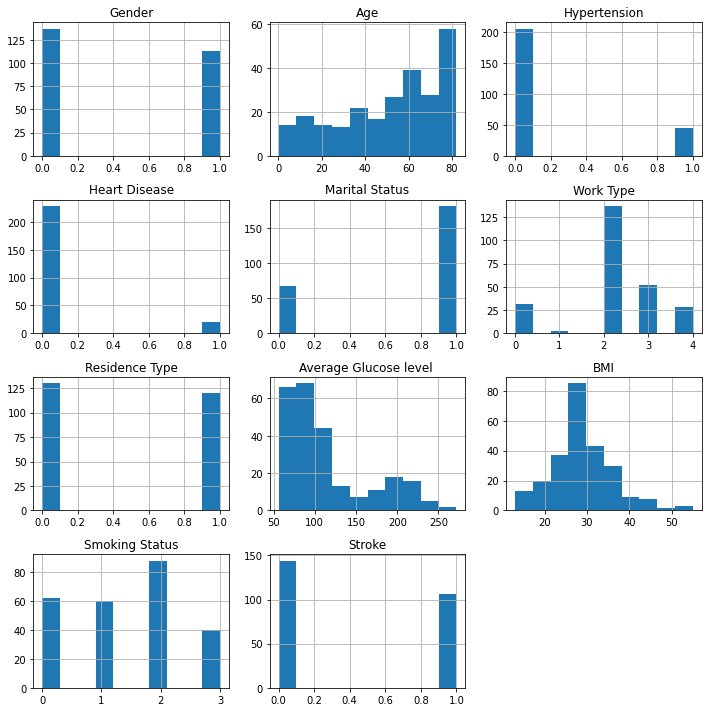

In [37]:
fig = clean_data.hist(figsize=(10,10))
plt.tight_layout()
plt.show()

## Balancing Target(Stroke) Class

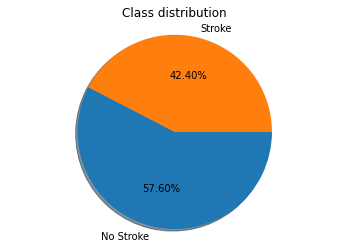

# samples associated with no stroke: 144
# samples associated with stroke: 106


In [38]:
class_occur = clean_data['Stroke'].value_counts()
class_names = ['No Stroke','Stroke']
fig, ax = plt.subplots()
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=0, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()
print("# samples associated with no stroke: {}".format(class_occur[0]))
print("# samples associated with stroke: {}".format(class_occur[1]))

## Handling Imbalanced Class

In [39]:
# create the  object with the desired sampling strategy.
smote = SMOTE(sampling_strategy='minority')

# fit the object to our training data
X, y = smote.fit_sample(clean_data.loc[:,clean_data.columns!='Stroke'], clean_data['Stroke'])
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (288, 10)
Shape of y: (288,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


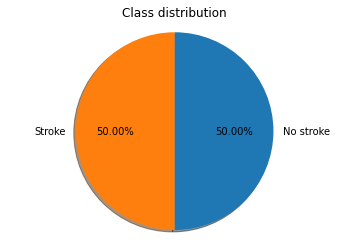

# samples associated with no stroke: 144
# samples associated with stroke: 144


In [40]:
_, class_counts = np.unique(y, return_counts=True)
class_names = ['No stroke', 'Stroke']
fig, ax = plt.subplots()
ax.pie(class_counts, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=90, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()
print("# samples associated with no stroke: {}".format(class_counts[0]))
print("# samples associated with stroke: {}".format(class_counts[1]))

## Data Splitting

In [41]:
def split_train_valid_test(X,y,test_size=0.1,random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=test_size/(1-test_size), random_state=random_state, stratify=y_train)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(X,y,test_size=0.1,random_state=42)
_, train_counts = np.unique(y_train, return_counts=True)
_, valid_counts = np.unique(y_valid, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
print("[train] # class 0: {} | # class 1: {}".format(train_counts[0],train_counts[1]))
print("[valid] # class 0: {} | # class 1: {}".format(valid_counts[0],valid_counts[1]))
print("[test]  # class 0: {} | # class 1: {}".format(test_counts[0],test_counts[1]))

[train] # class 0: 115 | # class 1: 115
[valid] # class 0: 14 | # class 1: 15
[test]  # class 0: 15 | # class 1: 14


## Data Normalize

In [42]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)
X_test_std = scaler.transform(X_test)

## Confusion Matrix

In [43]:
def calc_sens_spec(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true,y_pred)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    

## Decision Tree

In [44]:
dtree_model = DecisionTreeClassifier(random_state=42)
dtree_model.fit(X_train_std, y_train)
y_dtree = dtree_model.predict(X_test_std)
y_dtree_prob = dtree_model.predict_proba(X_test_std)

Classification report for DT: 
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.73      0.79      0.76        14

    accuracy                           0.76        29
   macro avg       0.76      0.76      0.76        29
weighted avg       0.76      0.76      0.76        29

Confusion matrix for DT: 
[[11  4]
 [ 3 11]]
Accuracy score for DT: 0.76
Precision score for DT: 0.73
Recall score for DT: 0.79
F1 score for DT: 0.76


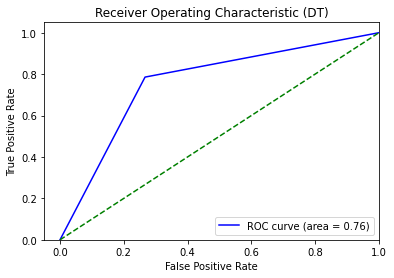

In [45]:
print("Classification report for DT: \n{}".format(classification_report(y_test,y_dtree)))
print("Confusion matrix for DT: \n{}".format(confusion_matrix(y_test,y_dtree)))
print("Accuracy score for DT: {:.2f}".format(accuracy_score(y_test,y_dtree)))
# calculate precision, recall, and f1 scores
prec_dtree = precision_score(y_test,y_dtree)
rec_dtree = recall_score(y_test,y_dtree)
f1_dtree = f1_score(y_test,y_dtree)
print("Precision score for DT: {:.2f}".format(prec_dtree))
print("Recall score for DT: {:.2f}".format(rec_dtree))
print("F1 score for DT: {:.2f}".format(f1_dtree))
fpr, tpr, _ = roc_curve(y_test,  y_dtree_prob[:,1])
auc_dtree = roc_auc_score(y_test, y_dtree_prob[:,1])
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_dtree)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (DT)')
ax.legend(loc="lower right")
plt.show()

## SVM

In [46]:
svm_model = SVC(kernel='rbf',probability=True)
svm_model.fit(X_train_std, y_train)
y_svm = svm_model.predict(X_test_std)
y_svm_prob = svm_model.predict_proba(X_test_std)

Classification report for SVM: 
              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.78      1.00      0.88        14

    accuracy                           0.86        29
   macro avg       0.89      0.87      0.86        29
weighted avg       0.89      0.86      0.86        29

Confusion matrix for SVM: 
[[11  4]
 [ 0 14]]
Accuracy score for SVM: 0.86
Precision score for SVM: 0.78
Recall score for SVM: 1.00
F1 score for SVM: 0.88


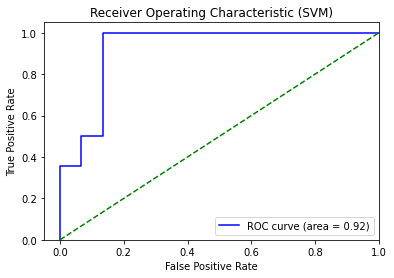

In [47]:
print("Classification report for SVM: \n{}".format(classification_report(y_test,y_svm)))
print("Confusion matrix for SVM: \n{}".format(confusion_matrix(y_test,y_svm)))
print("Accuracy score for SVM: {:.2f}".format(accuracy_score(y_test,y_svm)))
# calculate precision, recall, and f1 scores
prec_svm = precision_score(y_test,y_svm)
rec_svm = recall_score(y_test,y_svm)
f1_svm = f1_score(y_test,y_svm)
print("Precision score for SVM: {:.2f}".format(prec_svm))
print("Recall score for SVM: {:.2f}".format(rec_svm))
print("F1 score for SVM: {:.2f}".format(f1_svm))
fpr, tpr, _ = roc_curve(y_test,  y_svm_prob[:,1])
auc_svm = roc_auc_score(y_test, y_svm_prob[:,1])
fig, ax = plt.subplots()
ax.plot(fpr,tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_svm)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (SVM)')
ax.legend(loc="lower right")
plt.show()

## Performance Benchmark Across Models

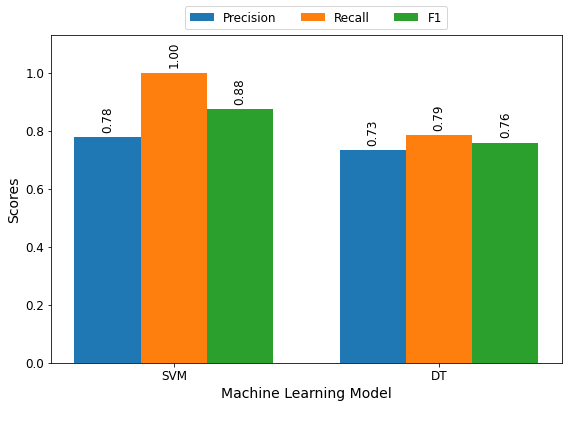

In [48]:
ml_names = ['SVM', 'DT']


prec_all = [prec_svm,prec_dtree]
rec_all = [rec_svm, rec_dtree]
f1_all = [f1_svm, f1_dtree]

def autolabel(bars):
    """Attach a text label above each bar in displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=12,
                    rotation=90,
                    ha='center', va='bottom')
        
width = 0.25  # the width of the bars
r1 = np.arange(len(ml_names))  # the label locations
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]



# plot sensitivity, specificity, and auc
fig, ax = plt.subplots(figsize=(8,6))
bar1 = ax.bar(r1, prec_all, width, label='Precision')
bar2 = ax.bar(r2, rec_all, width, label='Recall')
bar3 = ax.bar(r3, f1_all, width, label='F1')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,1.13])
ax.set_ylabel('Scores',fontsize=14)
#ax.set_title('Performance benchmark across ML models')
ax.set_xticks(r2)
ax.set_xticklabels(ml_names)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Machine Learning Model\n",fontsize=14)
ax.legend(loc='lower left',ncol=3,bbox_to_anchor=(0.25,1),fontsize=12)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
fig.savefig("ml_benchmark_f1.pdf", bbox_inches='tight')
plt.show()